# Quantum kernel estimation

## Outline

In this notebook we will carry out these steps several ways to make optimal use of your time on real quantum computers. We will apply a quantum kernel method to

1. A single kernel matrix entry for data with relatively few features, using a real backend, so that we can easily follow what is happening at each step.
2. An entire data set with relatively few features, using a simulated backend, so that we can see how the quantum workstream connects with classical machine learning methods

## Install required packages

In [5]:
%pip install panda

Note: you may need to restart the kernel to use updated packages.


## Download data set

In [7]:
# Download data set - try with curl instead of wget
!curl -L -o dataset_graph7.csv https://raw.githubusercontent.com/qiskit-community/prototype-quantum-kernel-training/main/data/dataset_graph7.csv

# Alternatively, if curl fails, try using Python requests
import requests
import os

# Only download if the file doesn't exist already
if not os.path.exists("dataset_graph7.csv"):
    try:
        print("Downloading using Python requests...")
        url = "https://raw.githubusercontent.com/qiskit-community/prototype-quantum-kernel-training/main/data/dataset_graph7.csv"
        response = requests.get(url)
        with open("dataset_graph7.csv", "wb") as file:
            file.write(response.content)
        print("Download completed!")
    except Exception as e:
        print(f"Error downloading: {e}")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 49405  100 49405    0     0  64962      0 --:--:-- --:--:-- --:--:-- 65350


In [9]:
import pandas as pd
df = pd.read_csv("dataset_graph7.csv", sep=",", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.193574,0.113979,-0.005927,0.300957,-0.358603,-0.087866,-0.156226,0.342442,-0.016003,0.143113,0.256422,-0.164125,-0.136743,0.014674,1.0
1,-0.100006,0.002431,0.244218,0.126870,-0.063891,-0.085588,0.072490,0.042986,-0.052714,0.019754,-0.159314,-0.409991,-0.199615,0.053845,-1.0
2,-1.774448,-0.047642,-0.025880,0.252708,-0.350689,-1.604509,-0.114874,0.347631,0.059501,-0.168956,0.351014,-0.128586,0.098897,-0.047799,1.0
3,-0.211585,-0.043782,-1.560226,0.018510,-0.051867,-0.128508,0.218609,-0.075632,-0.183656,-1.715292,-0.105361,-0.300758,-0.566431,0.046542,-1.0
4,-0.105965,0.208387,-0.003896,0.163816,-0.332541,-1.594675,-1.889321,-0.251937,0.374445,-1.431062,0.290588,0.118851,0.048799,-0.073023,1.0


## Single kernel matrix entry

### Step 1: Map classical inputs to a quantum problem

Let's look at the first two data points, which is the minimal needed for calculating the kernel matrix.

In [10]:
import numpy as np
import matplotlib.pyplot as plt

small_data = df.iloc[:2]
small_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.193574,0.113979,-0.005927,0.300957,-0.358603,-0.087866,-0.156226,0.342442,-0.016003,0.143113,0.256422,-0.164125,-0.136743,0.014674,1.0
1,-0.100006,0.002431,0.244218,0.126870,-0.063891,-0.085588,0.072490,0.042986,-0.052714,0.019754,-0.159314,-0.409991,-0.199615,0.053845,-1.0


In [11]:
# Features of the first data point
small_data.values[0,:-1]

array([-0.19357448,  0.11397916, -0.00592673,  0.30095717, -0.35860336,
       -0.08786632, -0.15622592,  0.3424416 , -0.01600324,  0.1431133 ,
        0.25642247, -0.16412547, -0.13674259,  0.01467435])

In [12]:
# Data points with labels removed, for inner product
train_data = small_data.values[:,:-1]
train_data

array([[-0.19357448,  0.11397916, -0.00592673,  0.30095717, -0.35860336,
        -0.08786632, -0.15622592,  0.3424416 , -0.01600324,  0.1431133 ,
         0.25642247, -0.16412547, -0.13674259,  0.01467435],
       [-0.10000625,  0.00243083,  0.24421757,  0.12686991, -0.06389124,
        -0.085588  ,  0.07249021,  0.04298629, -0.0527142 ,  0.01975425,
        -0.15931417, -0.40999085, -0.19961527,  0.05384521]])

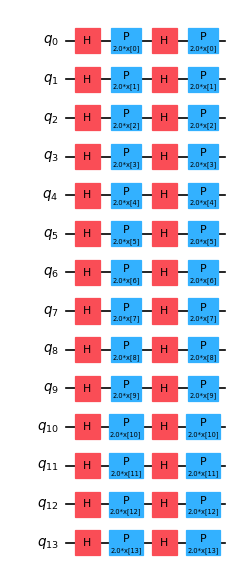

In [46]:
from qiskit.circuit.library import ZFeatureMap

fm = ZFeatureMap(feature_dimension=np.shape(train_data)[1])
fm.decompose().draw("mpl", scale=0.6)

In [14]:
unitary1 = fm.assign_parameters(train_data[0])
unitary2 = fm.assign_parameters(train_data[1])

circuit depth =  9


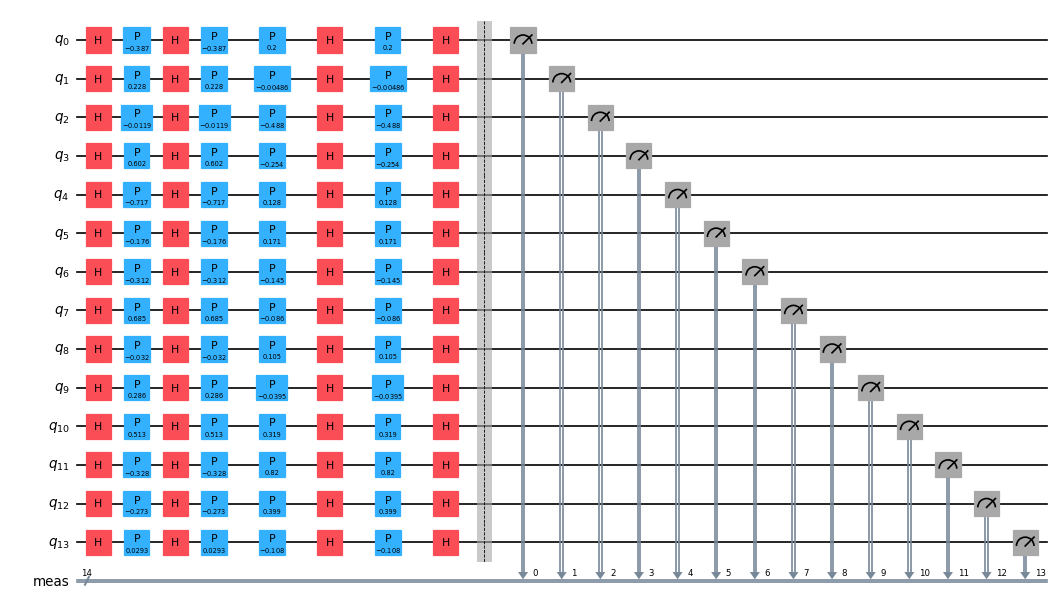

In [ ]:
from qiskit.circuit.library import UnitaryOverlap

overlap_circ = UnitaryOverlap(unitary1, unitary2)
overlap_circ.measure_all()

print("circuit depth = ", overlap_circ.decompose().depth())
overlap_circ.decompose().draw("mpl", scale=0.6)

### Step 2: Optimize problem for quantum execution

We start by selecting the least busy backend, then optimize our circuit for running on that backend.

In [16]:
# Import needed packages
from qiskit_ibm_runtime import QiskitRuntimeService

# Get the least busy backend
service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(
#     operational=True, simulator=False, min_num_qubits=fm.num_qubits
# )

backend = service.backend('ibm_strasbourg')  # You can change the backend

print(backend)

<IBMBackend('ibm_strasbourg')>


In [17]:
# Apply level 3 optimization to our overlap circuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
overlap_ibm = pm.run(overlap_circ)

circuit depth =  6
0


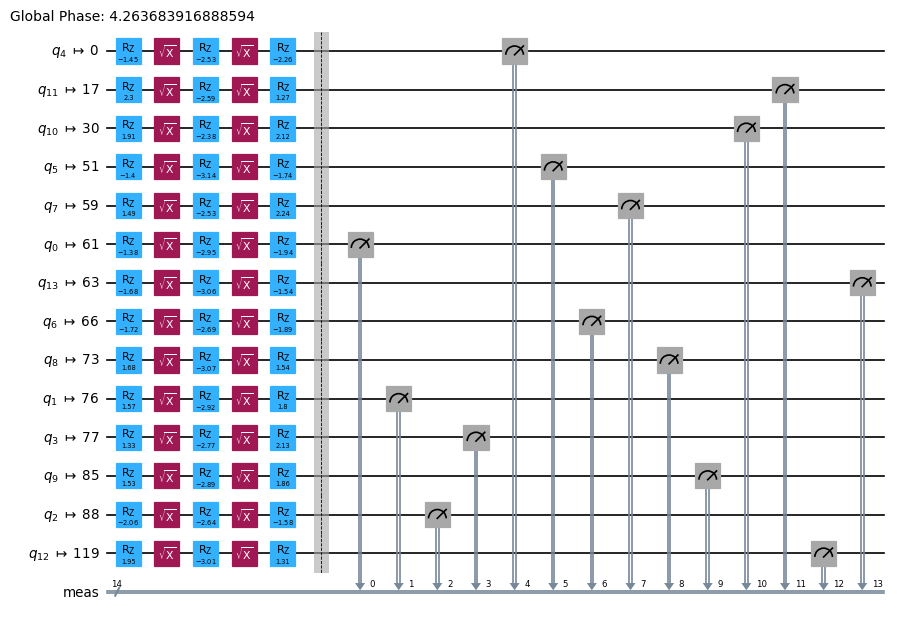

In [50]:
print("circuit depth = ", overlap_ibm.depth())
print(f"{overlap_ibm.depth(lambda x: x.operation.num_qubits == 2)}")
overlap_ibm.draw("mpl", scale=0.6,idle_wires=False)

### Step 3: Execute using Qiskit Runtime Primitives

The syntax for running on a simulator is commented out below. For this dataset, with a small number of features, running on a simulator is still an option. For utility-scale calculations, simulation is not typically feasible. Simulators should only be used to debug scaled-down code.

In [53]:
# Run this for a simulator
from qiskit.primitives import StatevectorSampler
from qiskit_ibm_runtime import Options, Session, Sampler

num_shots = 10000

# Evaluate the problem using state vector-based primitives from Qiskit
sampler = StatevectorSampler()
job = sampler.run([overlap_circ], shots=num_shots)
results = job.result()
# .get_counts() returns counts associated with a state labeled by bit results such as |001101...01>.
counts_bit = results[0].data.meas.get_counts()

### Step 4: Post-process, return result in classical format

As described in the introduction, the most useful measurement here is the probability of measuring the all zero state ∣000...00⟩.

In [ ]:
print("Valor esperado:",counts_bit.get('0'*len(train_data[0]))/num_shots)

# Lo que viene ahora lo he añadido yo, no estoy seguro de que sea correcto comparar las dos magnitudes
# Recuperar los dos primeros puntos de datos (excluyendo la etiqueta)
vector1 = small_data.values[0,:-1]  # Primera fila sin la etiqueta
vector2 = small_data.values[1,:-1]  # Segunda fila sin la etiqueta
# Calcular el producto interno
producto_interno = np.dot(vector1, vector2)
print(f"Producto interno: {producto_interno}")

Valor esperado: 0.5441
Producto interno: 0.14839303263693493


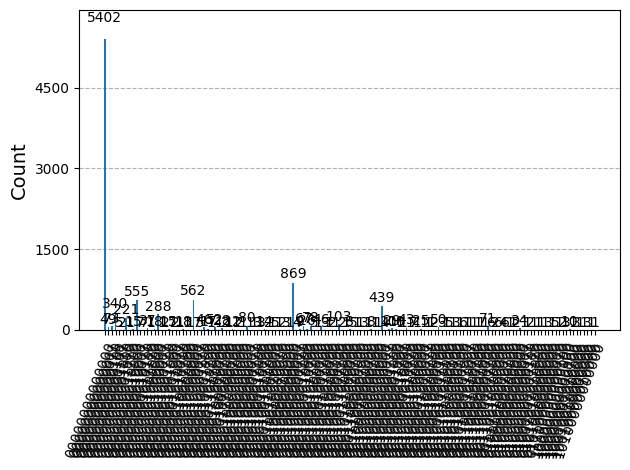

In [21]:
from qiskit.visualization import plot_histogram
plot_histogram(counts_bit)

It's hard to read with too many bitstrings. Let's use the following functions to show the top 10 bitstrings.

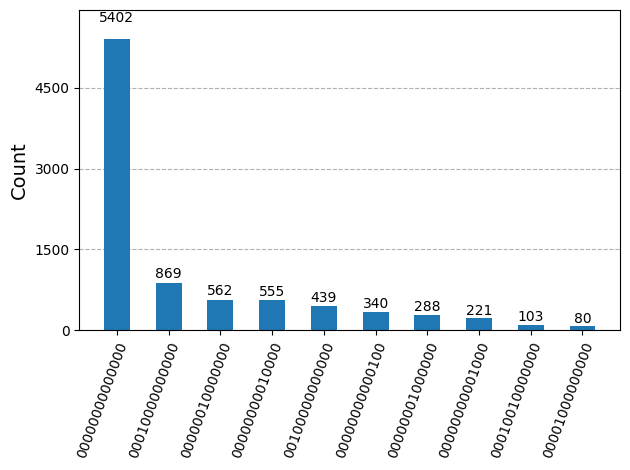

In [22]:
plot_histogram(data=counts_bit, sort='value_desc', number_to_keep=10)

## Full kernel matrix

Let's move on to calculating the full kernel matrix

### Step 1: Map classical inputs to a quantum problem

In [59]:
# Total number of data points in this data set
len(df)

128

Let's divide the data set into training data and testing data. 

In [60]:
# Prepare training data
train_size = 30
X_train=df.values[0:train_size,:-1]
train_labels = df.values[0:train_size,-1]

# Prepare testing data
test_size = 10
X_test=df.values[train_size:train_size+test_size,:-1]
test_labels=df.values[train_size:train_size+test_size,-1]

In [61]:
# Create empty kernel matrix
num_samples = np.shape(X_train)[0]
num_samples

30

In [63]:
kernel_matrix = np.full((num_samples, num_samples), np.nan)
print(kernel_matrix.shape)
kernel_matrix

(30, 30)


array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan,

In [27]:
test_matrix = np.full((test_size, num_samples), np.nan)
print(test_matrix.shape)
test_matrix

(10, 30)


array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan,

In [64]:
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit

# Prepare feature map for computing overlap
num_features = np.shape(X_train)[1]
num_qubits = int(num_features / 2)
print(f"Number of features: {num_features}")
print(f"Number of qubits: {num_qubits}")

Number of features: 14
Number of qubits: 7


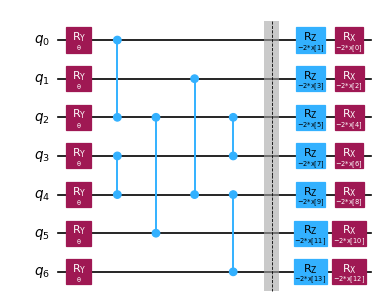

In [65]:
# To use a custom feature map use the lines below.

entangler_map = [[0, 2], [3, 4], [2, 5], [1, 4], [2, 3], [4, 6]]

fm = QuantumCircuit(num_qubits)
training_param = Parameter("θ")
feature_params = ParameterVector("x", num_qubits * 2)
fm.ry(training_param, fm.qubits)
for cz in entangler_map:
    fm.cz(cz[0], cz[1])
fm.barrier()
for i in range(num_qubits):
    fm.rz(-2 * feature_params[2 * i + 1], i)
    fm.rx(-2 * feature_params[2 * i], i)

fm.draw("mpl", scale=0.6)

### Step 2 & 3: Optimize problem & execute using primitives

In [77]:
def create_training_overlap_circuit_list(train_size, X_train, feature_map):
    training_overlap_circ_list = [
        UnitaryOverlap(
            feature_map.assign_parameters(list(X_train[x1]) + [np.pi / 2]),
            feature_map.assign_parameters(list(X_train[x2]) + [np.pi / 2])
        )
        for x1 in range(train_size) for x2 in range(x1 + 1, train_size)
    ]

    for circuit in training_overlap_circ_list:
        circuit.measure_all()

    return training_overlap_circ_list


def create_testing_overlap_circuit_list(test_size, train_size, X_test, X_train, feature_map):
    testing_overlap_circ_list = [
        UnitaryOverlap(
            feature_map.assign_parameters(list(X_test[x1]) + [np.pi / 2]),
            feature_map.assign_parameters(list(X_train[x2]) + [np.pi / 2])
        )
        for x1 in range(test_size) for x2 in range(train_size)
    ]

    for circuit in testing_overlap_circ_list:
        circuit.measure_all()

    return testing_overlap_circ_list


def compute_overlap_matrix(results, size1, size2, is_symmetric=False):
    """
    Compute the kernel or test matrix from the sampler results.

    Parameters:
    - results: The result object from sampler.run()
    - size1: Number of rows in the matrix (train_size or test_size)
    - size2: Number of columns in the matrix (train_size)
    - is_symmetric: If True, fills a symmetric kernel matrix.

    Returns:
    - A numpy array representing the computed overlap matrix.
    """
    overlap_matrix = np.zeros((size1, size2))
    idx = 0

    for x1 in range(size1):
        for x2 in range(x1 + 1, size2) if is_symmetric else range(size2):
            counts = results[idx].data.meas.get_int_counts()
            prob_0 = counts.get(0, 0.0) / num_shots

            overlap_matrix[x1, x2] = prob_0

            if is_symmetric:
                overlap_matrix[x2, x1] = prob_0  # Mirror value for symmetry

            idx += 1

        if is_symmetric:
            overlap_matrix[x1, x1] = 1  # Diagonal elements should be 1 for training data

    return overlap_matrix

In [78]:
# Running on a simulator
from qiskit.primitives import StatevectorSampler

# Evaluate the problem using state vector-based primitives from Qiskit.
sampler = StatevectorSampler()
num_shots = 10000

In [32]:
# # Running on a real hardware
# from qiskit_ibm_runtime import SamplerV2 as Sampler

# sampler = Sampler(mode=backend)

Create training circutis and submit job

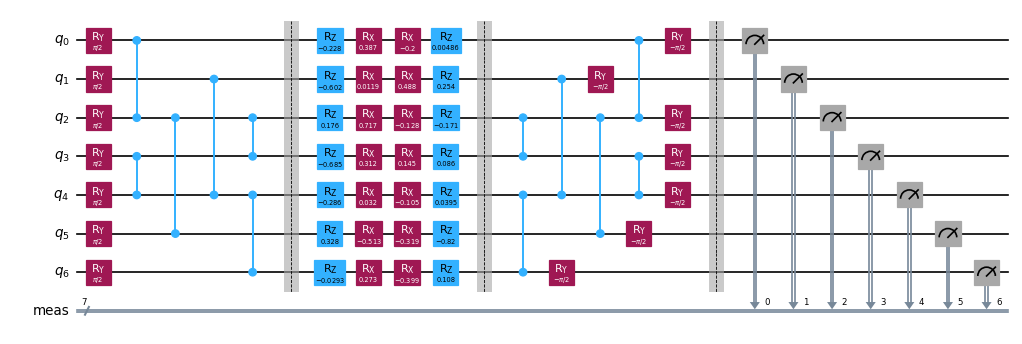

In [80]:
training_overlap_circ_list = create_training_overlap_circuit_list(train_size, X_train, fm)
job_training = sampler.run(training_overlap_circ_list, shots=num_shots)
training_overlap_circ_list[0].draw("mpl", scale=0.6, idle_wires=False)

Create testing circuits and submit job

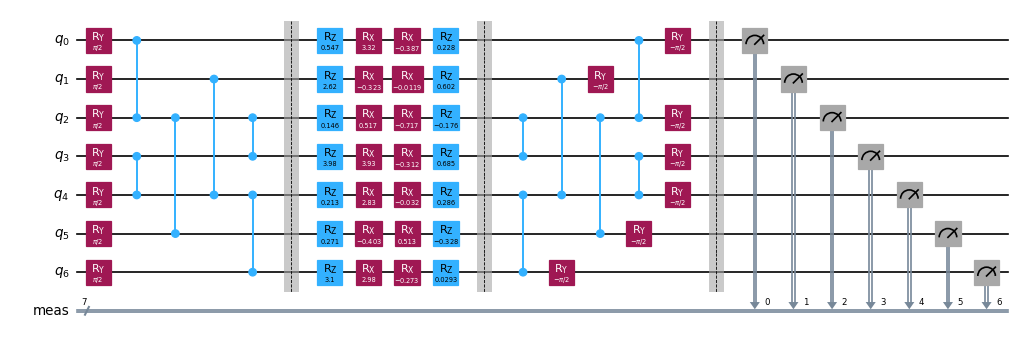

In [81]:
testing_overlap_circ_list = create_testing_overlap_circuit_list(test_size, train_size, X_test, X_train, fm)
job_testing = sampler.run(testing_overlap_circ_list, shots=num_shots)
testing_overlap_circ_list[0].draw("mpl", scale=0.6, idle_wires=False)

Compute training kernel matrix

In [35]:
results_training = job_training.result()
kernel_matrix = compute_overlap_matrix(results_training, train_size, train_size, is_symmetric=True)
print("Training matrix done")

Training matrix done


Compute test matrix

In [36]:
results_testing = job_testing.result()
test_matrix = compute_overlap_matrix(results_testing, test_size, train_size, is_symmetric=False)
print("Test matrix done")

Test matrix done


#### Running on real hardware

In [85]:
# Running on a real hardware
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)

Create training circutis and submit job

In [86]:
training_overlap_circ_list = create_training_overlap_circuit_list(train_size, X_train, fm)
pm = generate_preset_pass_manager(optimization_level=2, backend=backend)
isa_circuit_list = [pm.run(circuit) for circuit in training_overlap_circ_list]

In [87]:
job_training = sampler.run(isa_circuit_list, shots=num_shots)

Create testing circuits and submit job

In [88]:
testing_overlap_circ_list = create_testing_overlap_circuit_list(test_size, train_size, X_test, X_train, fm)
isa_circuit_list = [pm.run(circuit) for circuit in testing_overlap_circ_list]

In [89]:
job_testing = sampler.run(isa_circuit_list, shots=num_shots)

Compute training kernel matrix

In [90]:
results_training = job_training.result()
kernel_matrix = compute_overlap_matrix(results_training, train_size, train_size, is_symmetric=True)
print("Training matrix done")

Training matrix done


Compute test matrix

In [83]:
results_testing = job_testing.result()
test_matrix = compute_overlap_matrix(results_testing, test_size, train_size, is_symmetric=False)
print("Test matrix done")

Test matrix done


### Step 4: Post-process, return result in classical format

In [84]:
# import a support vector classifier from a classical ML package.
from sklearn.svm import SVC

#Specify that you want to use a pre-computed kernel matrix
qml_svc = SVC(kernel="precomputed")

In [ ]:
# Feed in the pre-computed matrix and the labels of the training data. The classical algorithm gives you a fit.
qml_svc.fit(kernel_matrix, train_labels)

SVC(kernel='precomputed')

In [ ]:
qml_svc.predict(test_matrix)

array([ 1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.])

In [ ]:
test_labels

array([ 1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.])

In [ ]:
# Now use the .score to test your data, using the matrix of test data, and test labels as your inputs.
qml_score_precomputed_kernel = qml_svc.score(test_matrix, test_labels)
print(f"Precomputed kernel classification test score: {qml_score_precomputed_kernel}")

Precomputed kernel classification test score: 1.0


## Further reading

If you want to learn more about Quantum Machine Learning, check out [the QML course](https://learning.quantum.ibm.com/course/quantum-machine-learning) on IBM Quantum Learning platform.

### Step 1: Map classical inputs to a quantum problem

In [ ]:
#Two mock data points, including category labels, as in training

large_data = [
    [-0.028,	-1.49,	-1.698,	0.107,	-1.536,	-1.538,	-1.356,	-1.514,	-0.109,	-1.8,	-0.122,	-1.651,	-1.955,	-0.123,	-1.732,	0.091,	-0.048,	-0.128,	-0.026,	0.082,	-1.263,	0.065,	0.004,	-0.055,	-0.08,	-0.173,	-1.734,	-0.39,	-1.451,	0.078,	-1.578,	-0.025,	-0.184,	-0.119,	-1.336,	0.055,	-0.204,	-1.578,	0.132,	-0.121,	-1.599,	-0.187,-1],
    [-1.414,	-1.439,	-1.606,	0.246,	-1.673,	0.002,	-1.317,	-1.262,	-0.178,	-1.814,	0.013,	-1.619,	-1.86,	-0.25,	-0.212,	-0.214,	-0.033,	0.071,	-0.11,	-1.607,	0.441,	-0.143,	-0.009,	-1.655,	-1.579,	0.381,	-1.86,	-0.079,	-0.088,	-0.058,	-1.481,	-0.064,	-0.065,	-1.507,	0.177,	-0.131,	-0.153,	0.07,	-1.627,	0.593,	-1.547,	-0.16,-1]
]
train_data = [large_data[0][:-1],large_data[1][:-1]]

In [ ]:
from qiskit.circuit.library import ZZFeatureMap

fm = ZZFeatureMap(feature_dimension=np.shape(train_data)[1], entanglement='linear', reps=1)

unitary1 = fm.assign_parameters(train_data[0])
unitary2 = fm.assign_parameters(train_data[1])

In [ ]:
from qiskit.circuit.library import UnitaryOverlap

overlap_circ = UnitaryOverlap(unitary1, unitary2)
overlap_circ.measure_all()

print("circuit depth = ", overlap_circ.decompose(reps = 2).depth())
print("two-qubit depth", overlap_circ.decompose().depth(lambda instr: len(instr.qubits) > 1))
#overlap_circ.draw("mpl", scale=0.6, style="iqp")

circuit depth =  251
two-qubit depth 165


In [ ]:
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit

# Prepare feature map for computing overlap

entangler_map = [    [3, 4], [2, 5], [1, 4], [2, 3], [4, 6], [7, 9], [10, 11], [9, 12], [8, 11], [9, 10], [11, 13], [14, 16], [17, 18], [16, 19], [15, 18], [16, 17], [18, 20]
]

In [ ]:
#Use the entangler map above to build a feature map

num_features = np.shape(train_data)[1]
num_qubits = int(num_features / 2)

fm = QuantumCircuit(num_qubits)
training_param = Parameter("θ")
feature_params = ParameterVector("x", num_qubits * 2)
fm.ry(training_param, fm.qubits)
for cz in entangler_map:
    fm.cz(cz[0], cz[1])
for i in range(num_qubits):
    fm.rz(-2 * feature_params[2 * i + 1], i)
    fm.rx(-2 * feature_params[2 * i], i)

In [ ]:
# Assign features of each data point to a unitary, an instance of the general feature map.

unitary1 = fm.assign_parameters(list(train_data[0])+ [np.pi / 2] )
unitary2 = fm.assign_parameters(list(train_data[1])+ [np.pi / 2] )

from qiskit.circuit.library import UnitaryOverlap

# Create the overlap circuit
overlap_circ = UnitaryOverlap(unitary1, unitary2)
overlap_circ.measure_all()

### Step 2: Optimize problem for quantum execution

In [ ]:
#Import needed packages
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

# Get the least busy backend
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=fm.num_qubits
)
print(backend)

<IBMBackend('ibm_cusco')>


In [ ]:
#Apply level 3 optimization to our overlap circuit
transpiled_qcs=[]
transpiled_depths=[]
transpiled_twoqubit_depths=[]
for i in range(1,20):
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
    overlap_ibm = pm.run(overlap_circ)
    transpiled_qcs.append(overlap_ibm)
    transpiled_depths.append(overlap_ibm.decompose().depth())
    transpiled_twoqubit_depths.append(overlap_ibm.decompose().depth(lambda instr: len(instr.qubits) > 1))

print("circuit depth = ", overlap_ibm.decompose().depth())

circuit depth =  65


In [ ]:
print(transpiled_depths)
print(transpiled_twoqubit_depths)

[65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65]
[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13]


In [ ]:
overlap_ibm = transpiled_qcs[1]

### Step 3: Execute using Qiskit Runtime Primitives

In [ ]:
#Run on ibm_osaka, 7-12-24, required 22 sec.

#Import our runtime primitive
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler

#Open a Runtime session:
session = Session(backend=backend)
num_shots = 10000
# Use sampler and get the counts

sampler = Sampler(mode=session)
options = sampler.options
options.dynamical_decoupling.enable = True
options.twirling.enable_gates = True
counts = (
        sampler.run([overlap_ibm], shots=num_shots).result()[0].data.meas.get_int_counts()
        )

# Close session after done
session.close()

### Step 4: Post-process, return result in classical format

In [ ]:
counts.get(0, 0.0)/num_shots

0.0026